# Ансамбли моделей машинного обучения. Часть 2.

In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from scipy.optimize import fmin_tnc
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score, root_mean_squared_error 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn import linear_model
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
mpg = pd.read_csv('C:\\MGTU\\6 semestr\\TMO\\auto-mpg.csv')

In [3]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [4]:
mpg.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [5]:
mpg = mpg[mpg['horsepower'] != '?']
mpg['horsepower'] = mpg['horsepower'].astype(float)

In [6]:
mpg.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [7]:
mpg = mpg.drop(columns=['car name'])

In [8]:
X = mpg.drop(columns=['mpg'])  # Признаки
y = mpg['mpg']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборки
mpg_X_train, mpg_X_test, mpg_y_train, mpg_y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Стекинг

In [9]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)  # Задаем степень полинома
X_train_poly = poly.fit_transform(mpg_X_train)
X_test_poly = poly.transform(mpg_X_test)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train_poly, mpg_y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test_poly)

In [10]:
root_mean_squared_error(mpg_y_test, y_pred)

3.1367700997320496

In [11]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(mpg_X_train, mpg_y_train)
    y_pred = model.predict(mpg_X_test)
    result = root_mean_squared_error(mpg_y_test, y_pred)
    print(model)
    print('RMSE={}'.format(result))

In [12]:
# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    BaggingRegressor(n_estimators=1000)
    
]:
    val_mae(model)
    print('==========================')
    print()

LinearRegression()
RMSE=3.4667210313792913

DecisionTreeRegressor()
RMSE=3.431352097233665

BaggingRegressor(n_estimators=1000)
RMSE=3.14769333969485



In [13]:
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset
# Используем библиотеку heamy
# набор данных
dataset = Dataset(mpg_X_train, mpg_y_train, mpg_X_test)
dataset_poly = Dataset(X_train_poly, mpg_y_train, X_test_poly)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={},name='lr')
model_bg = Regressor(dataset=dataset, estimator=BaggingRegressor, parameters={'n_estimators': 1000},name='bg')
model_pol = Regressor(dataset=dataset_poly, estimator=LinearRegression, parameters={},name='pol')

In [14]:
# Эксперимент 1
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: линейная регрессия

pipeline = ModelsPipeline(model_tree, model_lr)
stack_ds = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [3.994079321735586, 1.705992063507044, 3.498820228195117, 2.76731395396818, 2.712828060377412, 3.4841399494608725, 3.25228287528604, 2.2873289517257005, 2.3492210300648586, 3.1155478177581872]
Mean accuracy: 2.9167554252079
Standard Deviation: 0.6497375249314522
Variance: 0.4221588513040495


In [15]:
# Эксперимент 2
# Первый уровень - две модели: дерево и линейная регрессия
# Второй уровень: бэггинг

stacker = Regressor(dataset=stack_ds, estimator=BaggingRegressor)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [3.700301507985531, 2.029868376274678, 3.6541466172007935, 2.8320698004884535, 2.158460472860975, 3.1404222029694076, 3.727705771997121, 3.023950631104092, 3.023323849139253, 3.589306699161434]
Mean accuracy: 3.0879555929181737
Standard Deviation: 0.584481559730816
Variance: 0.3416186936653674


In [16]:
# Эксперимент 3
# Первый уровень - три модели: дерево, линейная регрессия и бэггинг
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_bg)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [3.6403189140413206, 1.6909385439581688, 3.1210478530807224, 2.473065494641954, 2.3501128326441725, 2.8243233216427135, 2.9219933081916283, 1.9200580654841277, 2.0337059543181066, 2.8611198803670104]
Mean accuracy: 2.5836684168369923
Standard Deviation: 0.5710718005216499
Variance: 0.326123001351039


In [17]:
# Эксперимент 4
# Первый уровень - три модели: дерево, линейная регрессия и бэггинг
# Второй уровень: бэггинг
# Результат хуже чем в эксперименте 3
stacker = Regressor(dataset=stack_ds3, estimator=BaggingRegressor)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [4.190184587222859, 2.025479109988547, 3.2168151951891795, 2.8040776759753334, 2.3644606559527235, 3.5579316209498533, 3.1367653361693395, 2.7487569037892436, 2.487028282392332, 3.3771962985159267]
Mean accuracy: 2.9908695666145335
Standard Deviation: 0.6044198778372512
Variance: 0.36532338872479764


In [18]:
# Эксперимент 5
# Первый уровень - три модели: дерево, полиномиальная регрессия и бэггинг
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_pol, model_bg)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [3.693460890209922, 1.7362629840497992, 2.925914053622691, 2.4064809567337697, 2.1615832387448415, 2.7713155319395057, 3.0275702509290308, 1.8464204482106956, 1.9708442676541493, 2.8133636162907356]
Mean accuracy: 2.5353216238385143
Standard Deviation: 0.587975570483654
Variance: 0.34571527148557835


In [19]:
# Эксперимент 6
# Первый уровень - 4 модели: дерево, линейная регрессия, полиномиальная регрессия и бэггинг
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_lr, model_bg, model_pol)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [3.6782230739738058, 1.7198164352717917, 2.9236976087077613, 2.3923579485934496, 2.1831396493077877, 2.77189449053814, 3.0225977428745616, 1.8552063113789952, 1.9744286618132019, 2.809894555135343]
Mean accuracy: 2.533125647759484
Standard Deviation: 0.5841646737497893
Variance: 0.3412483660571978


In [20]:
# Эксперимент 7
# Первый уровень - три модели: линейная регрессия, полиномиальная регрессия и бэггинг
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_lr, model_pol, model_bg)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [3.6784309511228805, 1.685230022434641, 2.922802920212812, 2.390807263842764, 2.1671003109396936, 2.7375956335473703, 3.014130519807417, 1.839176122515726, 1.9743037453991856, 2.810312877055171]
Mean accuracy: 2.521989036687766
Standard Deviation: 0.5898595357207732
Variance: 0.3479342718807261


In [21]:
# Эксперимент 8
# Первый уровень - 2 модели: полиномиальная регрессия и бэггинг
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_pol, model_bg)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=root_mean_squared_error)

Metric: root_mean_squared_error
Folds accuracy: [3.6929213456681556, 1.702684938698718, 2.925725511703319, 2.405297970060379, 2.150195841123143, 2.7447476431147777, 3.0199722261563258, 1.8250286520144705, 1.9686135646169518, 2.81285834277228]
Mean accuracy: 2.524804603592852
Standard Deviation: 0.5942477873268704
Variance: 0.3531304327428814


In [22]:
def vis_models_quality(array_metric, array_labels, str_header, figsize=(5, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)
    pos = np.arange(len(array_metric))
    rects = ax1.barh(pos, array_metric,
                     align='center',
                     height=0.5, 
                     tick_label=array_labels)
    ax1.set_title(str_header)
    for a,b in zip(pos, array_metric):
        plt.text(0.2, a-0.1, str(round(b,3)), color='white')
    plt.show()

In [35]:
# Результаты
array_labels = ['TREE+LR=>LR', 'TREE+LR=>BG', 'TREE+LR+BG=>LR', 'TREE+LR+BG=>BG', 'TREE+PR+BG=>LR', 'TREE+LR+PR+BG=>LR','LR+PR+BG=>LR', 'BG+PR=>LR']
array_mae = [2.943373023221235, 3.13874388562688, 2.578048722056443, 2.95848390445565, 2.5310358229314796, 2.53583835576526, 2.517015391925021, 2.5134377028831354]

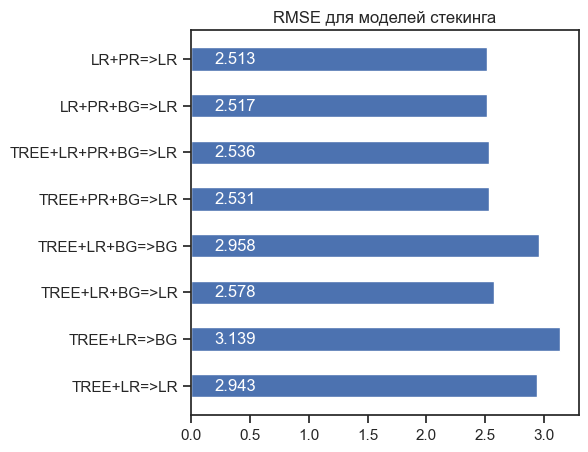

In [24]:
vis_models_quality(array_mae, array_labels, 'RMSE для моделей стекинга')

### Многослойный персептрон

In [25]:
from sklearn.neural_network import  MLPRegressor

In [26]:
mlp = MLPRegressor()
mlp.fit(mpg_X_train, mpg_y_train)

C:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor()

In [27]:
root_mean_squared_error(mpg_y_test, mlp.predict(mpg_X_test))

3.684623254170565

In [28]:
import warnings
warnings.filterwarnings('ignore')
from time import time
i = 0
df = pd.DataFrame(columns = ['alpha','max_iter','test_rmse','train_time'])
for a in [0.00001,0.0001,0.001,0.01, 0.1, 1, 10]:
    for mi in [10,100,200,500,1000,2000]:
        for l in [10,20,50,100,200,500,1000]:
            st = time()
            mlp = MLPRegressor(alpha=a, max_iter=mi, hidden_layer_sizes=(l,))
            mlp.fit(mpg_X_train, mpg_y_train)
            end = time() - st
        
            rmse = root_mean_squared_error(mpg_y_test, mlp.predict(mpg_X_test))
            df.loc[i] = [a,mi,rmse,end]
            i=i+1

In [29]:
df.sort_values(by = 'test_rmse')

,alpha,max_iter,test_rmse,train_time
80,0.00010,2000.0,3.215060,0.664493
191,0.10000,500.0,3.251294,0.672658
108,0.00100,500.0,3.252436,0.608567
114,0.00100,1000.0,3.329298,0.400934
159,0.01000,1000.0,3.334643,0.745109
...,...,...,...,...
210,1.00000,10.0,647.321807,0.007994
169,0.10000,10.0,699.505531,0.008001
1,0.00001,10.0,784.989586,0.008019
7,0.00001,100.0,1070.706551,0.056035


In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'max_iter': [10, 100, 200, 500, 1000, 2000],
    'hidden_layer_sizes': [(10,), (20,), (50,), (100,), (200,), (500,), (1000,)]
}



# Создание модели
mlp = MLPRegressor()

# Настройка Grid Search
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

# Время начала поиска
start_time = time()

# Выполнение Grid Search
grid_search.fit(mpg_X_train, mpg_y_train)

# Время окончания поиска
end_time = time() - start_time

# Получение результатов
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Создание DataFrame с результатами
results = pd.DataFrame(grid_search.cv_results_)

print(f"Лучшие параметры: {best_params}")
print(f"Лучший RMSE: {-best_score}")
print(f"Время выполнения: {end_time} секунд")

# Предсказание и оценка на тестовых данных
best_model = grid_search.best_estimator_
test_rmse = root_mean_squared_error(mpg_y_test, best_model.predict(mpg_X_test))

print(f"RMSE на тестовых данных: {test_rmse}")

Fitting 5 folds for each of 294 candidates, totalling 1470 fits
Лучшие параметры: {'alpha': 0.001, 'hidden_layer_sizes': (500,), 'max_iter': 2000}
Лучший RMSE: 3.2641124909333152
Время выполнения: 103.81544375419617 секунд
RMSE на тестовых данных: 3.7211813370982614


### МГУА 

In [31]:
from gmdh import Combi, Multi, Mia, Ria
from sklearn.preprocessing import StandardScaler
# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(mpg_X_train)
X_test = scaler.transform(mpg_X_test)
# Преобразование данных в тензоры NumPy
mpg_X_train = np.array(X_train)
mpg_y_train = np.array(mpg_y_train)
mpg_X_test = np.array(X_test)
mpg_y_test = np.array(mpg_y_test)

model = Ria()
model.fit(mpg_X_train, mpg_y_train)
y_pred = model.predict(mpg_X_test)
result = root_mean_squared_error(mpg_y_test, y_pred)
print(model)
print('RMSE={}'.format(result))

RMSE=3.0558788306195948


In [32]:
def print_metrics(y_test, y_pred, squared=False):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    crit_name = "MSE" if squared else "RMSE"
    print(f"{crit_name}: {mean_squared_error(y_test, y_pred, squared=squared)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")


In [33]:
from gmdh import CriterionType
from gmdh import Criterion 
from gmdh import Solver, PolynomialType
mpg_ria_model = Ria()
mpg_ria_model.fit(mpg_X_train, mpg_y_train, verbose=1, n_jobs=-1, test_size=0.53, limit=0, k_best=1, 
                  criterion = Criterion(criterion_type=CriterionType.STABILITY, solver = Solver.ACCURATE), p_average = 3)
mpg_y_pred_ria = mpg_ria_model.predict(mpg_X_test)
print_metrics(mpg_y_test, mpg_y_pred_ria)

LEVEL 1  [=========================] 100% :00s] (21 combinations) error=2611.884785                                                                                                
LEVEL 2  [=========================] 100% :00s] (7 combinations) error=2321.174477                                                                                                 
LEVEL 3  [=========================] 100% :00s] (7 combinations) error=2291.852059                                                                                                 
LEVEL 4  [=========================] 100% :00s] (7 combinations) error=2266.391443                                                                                                 
LEVEL 5  [=========================] 100% :00s] (7 combinations) error=2238.806791                                                                                                 
LEVEL 6  [=========================] 100% :00s] (7 combinations) error=2197.496964                  

C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [34]:
from gmdh import SequentialCriterion  
mpg_ria_model = Ria()
mpg_ria_model.fit(mpg_X_train, mpg_y_train, verbose=1, n_jobs=-1, test_size=0.52, limit=0, k_best=1, 
                  criterion = SequentialCriterion(criterion_type=CriterionType.SYM_REGULARITY, 
                                    second_criterion_type=CriterionType.SYM_STABILITY, solver=Solver.ACCURATE))
mpg_y_pred_ria = mpg_ria_model.predict(mpg_X_test)
print_metrics(mpg_y_test, mpg_y_pred_ria)

LEVEL 1  [=========================] 100% :00s] (21 combinations) error=5209.485939                                                                                                
LEVEL 2  [=========================] 100% :00s] (7 combinations) error=4643.248172                                                                                                 
LEVEL 3  [=========================] 100% :00s] (7 combinations) error=4590.687159                                                                                                 
LEVEL 4  [=========================] 100% :00s] (7 combinations) error=4556.00767                                                                                                  
LEVEL 5  [=========================] 100% :00s] (7 combinations) error=4508.576793                                                                                                 
LEVEL 6  [=========================] 100% :00s] (7 combinations) error=4421.003715                  

C:\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
